In [1]:
from axikernels.core.handlers import element_output, station_output, obspy_output
from axikernels.core.kernels import objective_function, kernel
from axikernels.aux import mesher
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

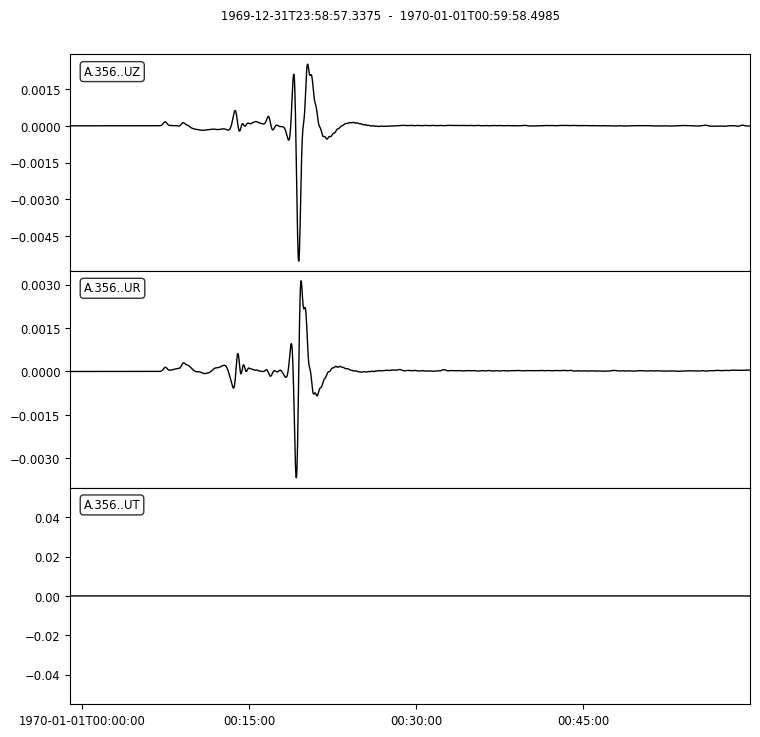

In [2]:
%matplotlib inline
forward_simulation_station = station_output.StationOutput(path_to_station_output='data/EXAMPLE_FORWARD/output/stations/Station_grid')
data_stream = forward_simulation_station.stream(networks=['A'], station_names=['356'], channels=['UR', 'UT', 'UZ'])
data_stream.plot(equal_scale=False)
plt.show()

In [3]:
station_location = forward_simulation_station.inventory.get_coordinates('A.356..UR')
point = np.array(
        [6371000 - station_location['elevation'],
         station_location['latitude'],
         station_location['longitude']]
)


Network and station are randomly generated here

Loading and interpolating: 100%|██████████| 1/1 [00:00<00:00, 435.32point/s]


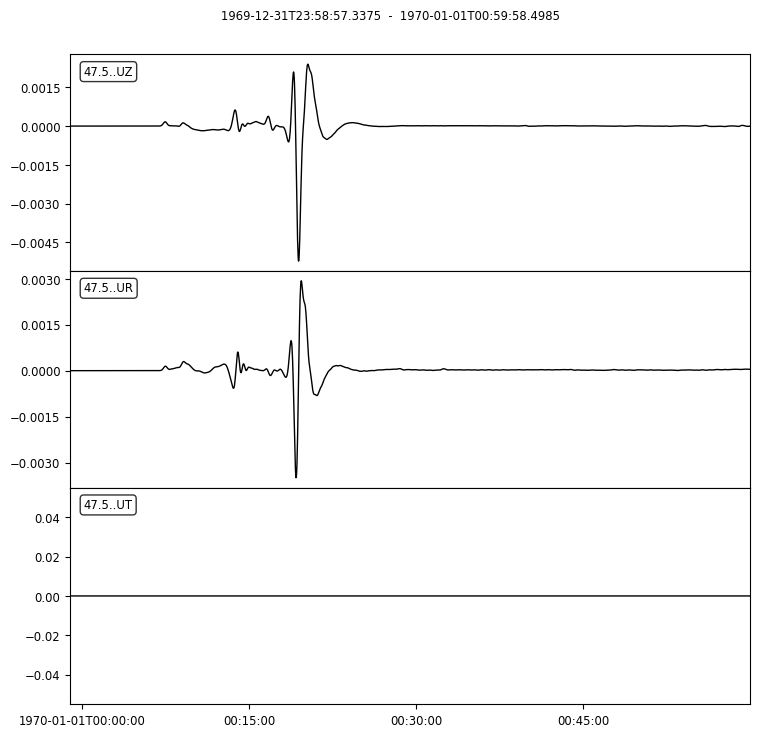

In [4]:
forward_simulation_element = element_output.ElementOutput(path_to_element_output='data/EXAMPLE_FORWARD/output/elements')
data_element = forward_simulation_element.stream(points=point, channels=['UR', 'UT', 'UZ'])
data_element.plot(equal_scale=False)
plt.show()


In [5]:
real_simulation = station_output.StationOutput('data/EXAMPLE_3D/output/stations/Station_grid')
real_simulation.obspyfy()


In [6]:
data_real = real_simulation.load_data_at_station(network='A', station_name='356', channels=['UR', 'UT', 'UZ'])
interpolation_functions = [interp1d(real_simulation.data_time, row, kind='linear') for row in data_real]
interpolated_real_data = np.array([f(forward_simulation_station.data_time) for f in interpolation_functions])

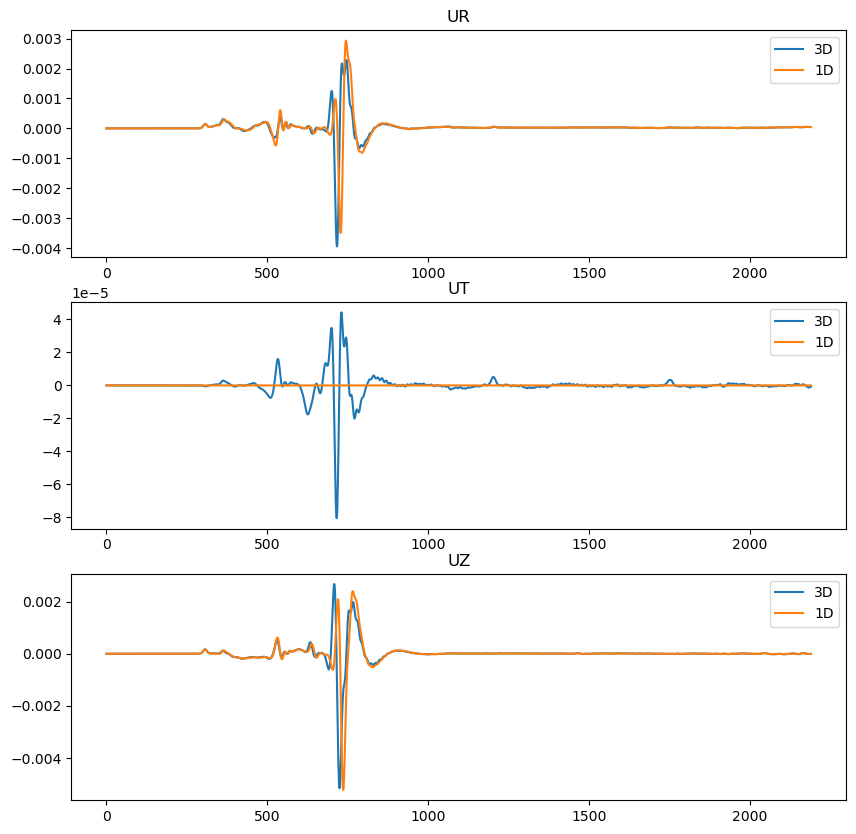

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for i, channel in enumerate(['UR', 'UT', 'UZ']):
    axs[i].plot(interpolated_real_data[i], label='3D')
    axs[i].plot(data_element[i].data, label='1D')
    axs[i].set_title(channel)
    axs[i].legend()

In [8]:
""" forward_simulation_element.animation(source_location=np.array([6371000, 0, 0]),
                                     station_location=np.array([6371000, 0, 50]),
                                     channels=['UR'], name='UR',
                                     video_duration=10, resolution=500) """

" forward_simulation_element.animation(source_location=np.array([6371000, 0, 0]),\n                                     station_location=np.array([6371000, 0, 50]),\n                                     channels=['UR'], name='UR',\n                                     video_duration=10, resolution=500) "

Loading and interpolating: 100%|██████████| 1/1 [00:00<00:00, 265.33point/s]


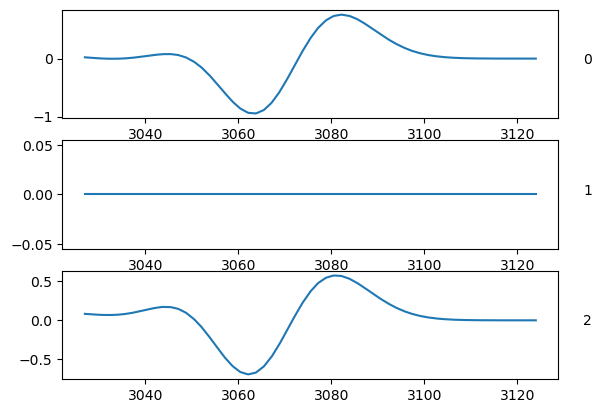

In [9]:


obj_func = objective_function.XObjectiveFunction(forward_data = forward_simulation_element,
                                                 real_data = obspy_output.ObspyfiedOutput('data/EXAMPLE_3D/output/stations/Station_grid/obspyfied'),)
obj_func._make_backward_directory()
obj_func._compute_adjoint_STF(network='A', station='356', location='',
                              real_channels=['UR', 'UT', 'UZ'],
                              window_left=475, window_right=575)


In [10]:
backward_element = element_output.ElementOutput(path_to_element_output='data/backward_EXAMPLE_FORWARD/output/elements')

No catalogues were found.


In [11]:
""" backward_element.animation(source_location=np.array([6371000, 0, 0]),
                            station_location=np.array([6371000, 0, np.radians(50)]),
                            channels=['UR'], name='UR',
                            video_duration=10, resolution=500) """

" backward_element.animation(source_location=np.array([6371000, 0, 0]),\n                            station_location=np.array([6371000, 0, np.radians(50)]),\n                            channels=['UR'], name='UR',\n                            video_duration=10, resolution=500) "

In [12]:
forward_simulation_element.base_model['DATA'].keys()

dict_keys(['radius', 'rho', 'vp', 'vs', 'qka', 'qmu'])

Loading and interpolating: 100%|██████████| 2322/2322 [00:01<00:00, 2205.06point/s]


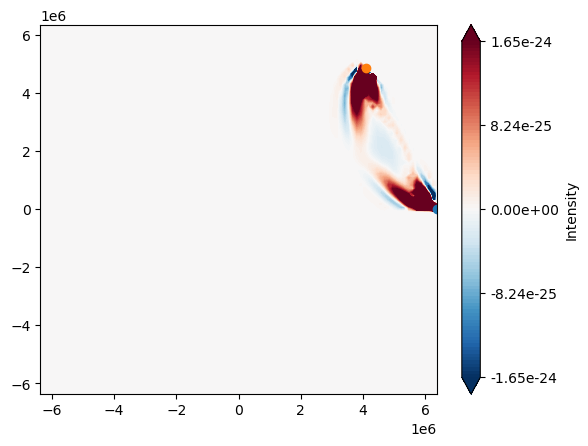

In [21]:
ker = kernel.Kernel(forward_obj=forward_simulation_element,
                    backward_obj=backward_element)
ker.evaluate_on_slice(source_location=np.array([6371000, 0, 0]),
                    station_location=np.array([6371000, 0, np.radians(50)]),
                    domains=[[4000000, 6371000, 0, np.pi]],
                    resolution=100, high_range=0.2)